In [15]:
import os
import pandas as pd
from zipfile import ZipFile

file_name = 'datasets.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

ENTERTAINMENT_DIR = os.path.join('.', 'datasets/Newswire/entertainment/bodies')
INTERNATIONAL_DIR = os.path.join('.', 'datasets/Newswire/international/bodies')
NATIONAL_DIR = os.path.join('.', 'datasets/Newswire/national/bodies')
POLITICS_DIR = os.path.join('.', 'datasets/Newswire/politics/bodies')
SPORTS_DIR = os.path.join('.', 'datasets/Newswire/sports/bodies')

def read_into_pandas():
    text_list = []
    
    for f in os.listdir(ENTERTAINMENT_DIR):
        with open(os.path.join(ENTERTAINMENT_DIR, f), 'r', encoding='utf-8') as fs:
            text_list.append({'id': f[0:-4], 'text': fs.read(), 'category':'ENTERTAINMENT'})

    for f in os.listdir(INTERNATIONAL_DIR):
        with open(os.path.join(INTERNATIONAL_DIR, f), 'r', encoding='utf-8') as fs:
            text_list.append({'id': f[0:-4], 'text': fs.read(), 'category':'INTERNATIONAL'})

    for f in os.listdir(NATIONAL_DIR):
        with open(os.path.join(NATIONAL_DIR, f), 'r', encoding='utf-8') as fs:
            text_list.append({'id': f[0:-4], 'text': fs.read(), 'category':'NATIONAL'})
    
    for f in os.listdir(POLITICS_DIR):
        with open(os.path.join(POLITICS_DIR, f), 'r', encoding='utf-8') as fs:
            text_list.append({'id': f[0:-4], 'text': fs.read(), 'category':'POLITICS'})

    for f in os.listdir(SPORTS_DIR):
        with open(os.path.join(SPORTS_DIR, f), 'r', encoding='utf-8') as fs:
            text_list.append({'id': f[0:-4], 'text': fs.read(), 'category':'SPORTS'})

    return pd.DataFrame(text_list, columns=['id', 'text', 'category'])

df = read_into_pandas()
print(df.head())
print(df.columns)

Done
                                 id  ...       category
0  DK4I1HTWLTUOHQM3ZMINUWLFJBX9Q7IW  ...  ENTERTAINMENT
1  CPNWH5LCKX6LX35PIBE28VDBRYXJFSVP  ...  ENTERTAINMENT
2  UK13NZT670QBHRTNWLLYG6KD5VVIOVAP  ...  ENTERTAINMENT
3  O8NTVAEGRCH6DJUPZ08WYABUMBUJV4SG  ...  ENTERTAINMENT
4  31C7ROE8HIKYAWM3ZBSA5KERNQWBINEO  ...  ENTERTAINMENT

[5 rows x 3 columns]
Index(['id', 'text', 'category'], dtype='object')


In [16]:
from sklearn.preprocessing import LabelEncoder

def replace_column_with_label_representation(df, cname, new_cname, le=None):
    if not le:
        le = LabelEncoder()
        df2 = pd.DataFrame(le.fit_transform(df[cname]), columns=[new_cname])
    else:
        df2 = pd.DataFrame(le.transform(df[cname]), columns=[new_cname])

    combined_df = pd.concat([df, df2], axis=1)
    del combined_df[cname]
    
    return (le, combined_df)

In [17]:
!pip install ktrain
import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split

In [18]:
# 1 get data into dataframe
df = read_into_pandas()
(lb_category, df) = replace_column_with_label_representation(df, 'category', 'category_int')
df_train, df_test = train_test_split(df, test_size=0.2)    

train_X = df_train['text'].values
train_y = df_train['category_int'].values
test_X = df_test['text'].values
test_y = df_test['category_int'].values

In [19]:
# 2 (distil)bert version
model_name = 'distilbert-base-uncased'
class_names = lb_category.classes_
trans = text.Transformer(model_name, maxlen=512, class_names=class_names)

preprocessing train...
language: en
train sequence lengths:
	mean : 958
	95percentile : 2044
	99percentile : 4121


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 924
	95percentile : 2274
	99percentile : 2743


simulating training for different learning rates... this may take a few moments...
12/12 [==============================] - 572s 48s/step - loss: 66.8935 - accuracy: 0.2500


done.
Visually inspect loss plot and select learning rate associated with falling loss


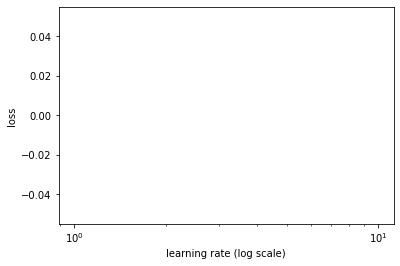



begin training using onecycle policy with max lr of 0.0001...
13/13 [==============================] - 659s 51s/step - loss: 1.5205 - accuracy: 0.4200 - val_loss: 1.3356 - val_accuracy: 0.6200
               precision    recall  f1-score   support

ENTERTAINMENT       0.33      1.00      0.50         2
INTERNATIONAL       0.70      0.58      0.64        12
     NATIONAL       0.47      0.70      0.56        10
     POLITICS       0.80      0.57      0.67        14
       SPORTS       0.78      0.58      0.67        12

     accuracy                           0.62        50
    macro avg       0.62      0.69      0.61        50
 weighted avg       0.69      0.62      0.63        50

[[2 0 0 0 0]
 [3 7 1 0 1]
 [1 0 7 1 1]
 [0 0 6 8 0]
 [0 3 1 1 7]]
----------
id:45 | loss:2.09 | true:INTERNATIONAL | pred:ENTERTAINMENT)

----------
id:14 | loss:2.01 | true:INTERNATIONAL | pred:ENTERTAINMENT)

----------
id:25 | loss:1.97 | true:INTERNATIONAL | pred:NATIONAL)

----------
id:11 | loss:1.8

In [21]:
# 3 train
train_data = trans.preprocess_train(train_X, train_y)
test_data = trans.preprocess_test(test_X, test_y)
model = trans.get_classifier()
learner = ktrain.get_learner(model, train_data, val_data=test_data, batch_size=16, use_multiprocessing=True)
learner.lr_find(show_plot=True, max_epochs=1)
best_lr = 0.0001
learner.fit_onecycle(best_lr, epochs=1)
cm = learner.validate(class_names=trans.get_classes())
print(cm)
tl = learner.view_top_losses(n=5, preproc=trans)
print(tl)


In [23]:

# 4 test
predictor = ktrain.get_predictor(learner.model, preproc=trans)
test_string = 'The Chiefs beat the Ravens last night 32-25.'
prediction = predictor.predict(test_string)
print(prediction)
#expl = predictor.explain()
#print(expl)
predictor.save('models/ktrain1')

NATIONAL
